# Analyse ROMY Event - Demo 1

ROMY data of an M6.8 event in 2023 is analyzed loading data from a local MSEED file.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from obspy import UTCDateTime
from sixdegrees.sixdegrees import sixdegrees

from sixdegrees.plots.plot_waveform_cc import plot_waveform_cc
from sixdegrees.plots.plot_cwt_all import plot_cwt_all
from sixdegrees.plots.plot_velocities import plot_velocities
from sixdegrees.plots.plot_backazimuth_results import plot_backazimuth_results
from sixdegrees.plots.plot_spectra_comparison_fill import plot_spectra_comparison_fill


## Configurations

Here we load the data from a local mseed file (data_source = "mseed_file"). All parameters for the processing and plotting are set hereafter in the configuration dictionary.

In the MSEED file the station was renamed to XX.ROMY..*

In [2]:
config = {
    # Required time window parameters
    'tbeg': "2023-09-08 22:13:00",  # Start time
    'tend': "2023-09-08 23:00:00",  # End time

    # event
    'origin_time': "2023-09-08 22:11:00",
    'magnitude': 6.8,

    # Station coordinates (required)
    'station_lon': 11.275476,  # BSPF longitude
    'station_lat': 48.162941,    # BSPF latitude
    
    # SEED identifiers
    'seed': "XX.ROMY..",     # Default seed ID
    'rot_seed': ["XX.ROMY..BJZ", "XX.ROMY..BJN", "XX.ROMY..BJE"], # "BW.ROMY.30.BJ*",  # Rotation sensor seed ID
    'tra_seed': ["XX.ROMY..BHZ", "XX.ROMY..BHN", "XX.ROMY..BHE"],  # Translation sensor seed ID
    
    # Data source
    'data_source': "mseed_file",  # "fdsn" | "sds" | "mseed_file"

    # Path to local mseed file
    'path_to_mseed_file': "./data/romy_eventM6.8.mseed",  # "./data/eventM62_6c.mseed",

    # Path configurations
    'workdir': "./",            # Working directory
    'path_to_data_out': "./output/",  # Output directory

    # Project information
    'project': "ROMY_Analysis",  # Project name
    
    # Backazimuth calculation parameters
    'baz_step': 1,               # Step size for backazimuth search in degrees
    'twin_sec': 30,          # Window length in seconds
    'twin_overlap': 0.5,  # Window overlap in seconds
    'cc_threshold': 0.75,        # Cross-correlation threshold

    # Filter parameters
    'fmin': 0.02,               # Minimum frequency for filtering
    'fmax': 0.2,                # Maximum frequency for filtering
    
    # Optional parameters
    'verbose': True,            # Print detailed information
}

Setup a sixdegrees object

In [3]:
sd = sixdegrees(conf=config)

Get key information about the event

In [4]:
ev = sd.get_event_info(
    origin_time=config['origin_time'],
    base_catalog="USGS",
    magnitude=config['magnitude']
)

Found event:
Origin time: 2023-09-08T22:11:01.405000Z
Magnitude: 6.8 mww
Location: 31.058°N, -8.385°E
Depth: 19.0 km
Epicentral Distance: 2526.01 km
Epicentral Distance: 22.7°
Backazimuth: 228.40°


This will load the data from the data source:
- local mseed file
- local sds system
- fdsn (online)

and trim it to the time window

Store the configuration as a yaml file

In [5]:
# define filename
filename = "./config/config_ROMY_M6.8_20230908.yml"

# store the configuration as a yaml file
sd.store_as_yaml(config, filename)


 -> file ./config/config_ROMY_M6.8_20230908.yml already exists. Aborting...


In [6]:
sd.load_data(config['tbeg'], config['tend'], resample_rate=5)

-> fetching XX.ROMY..BHZ data from mseed file
-> fetching XX.ROMY..BHN data from mseed file
-> fetching XX.ROMY..BHE data from mseed file
3 Trace(s) in Stream:
XX.ROMY..BHZ | 2023-09-08T22:12:58.989999Z - 2023-09-08T23:00:00.989999Z | 20.0 Hz, 56441 samples
XX.ROMY..BHN | 2023-09-08T22:12:58.990000Z - 2023-09-08T23:00:00.990000Z | 20.0 Hz, 56441 samples
XX.ROMY..BHE | 2023-09-08T22:12:58.990000Z - 2023-09-08T23:00:00.990000Z | 20.0 Hz, 56441 samples
-> fetching XX.ROMY..BJZ data from mseed file
-> fetching XX.ROMY..BJN data from mseed file
-> fetching XX.ROMY..BJE data from mseed file
3 Trace(s) in Stream:
XX.ROMY..BJZ | 2023-09-08T22:12:59.011600Z - 2023-09-08T23:00:01.011600Z | 20.0 Hz, 56441 samples
XX.ROMY..BJN | 2023-09-08T22:12:58.999400Z - 2023-09-08T23:00:00.999400Z | 20.0 Hz, 56441 samples
XX.ROMY..BJE | 2023-09-08T22:12:59.036600Z - 2023-09-08T23:00:00.986600Z | 20.0 Hz, 56440 samples
-> resampling stream to 5 Hz
6 Trace(s) in Stream:
XX.ROMY..LHZ | 2023-09-08T22:12:58.989999

Ensure that all traces of stream have the same sample size

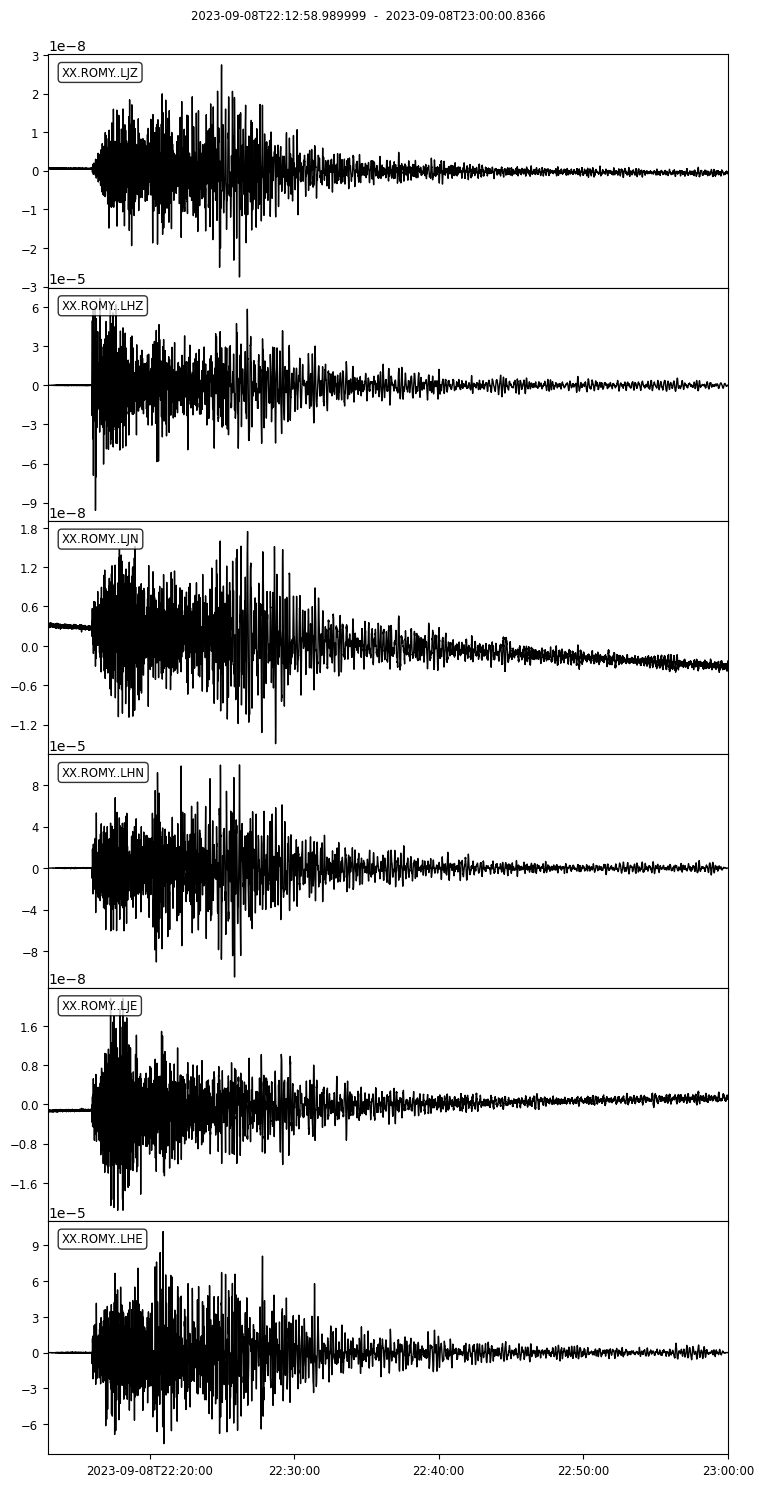

In [7]:
sd.st.plot(equal_scale=False);

Ensure alls traces have the same amount of samples

In [8]:
sd.trim_stream(set_common=True, set_interpolate=False)

## Analysis

### Wavelet Comparsion

In [9]:
# # First compute CWT for all components
# cwt_results = {}
# for comp in ['Z', 'N', 'E']:

#     try:
#         # Rotation components
#         rot_data = sd.get_stream("rotation").select(channel=f"*{comp}")[0]
#         cwt_results[f"{rot_data.stats.channel}"] = sd.compute_cwt(
#             rot_data.times(),
#             rot_data.data,
#             rot_data.stats.delta,
#             normalize=True,
#             fmax=1,
#             fmin=0.01
#         )
#     except:
#         print(f"No {comp} data for rotation")
#     try:
#         # Translation components
#         acc_data = sd.get_stream("translation").select(channel=f"*{comp}")[0]
#         cwt_results[f"{acc_data.stats.channel}"] = sd.compute_cwt(
#             acc_data.times(),
#             acc_data.data,
#             acc_data.stats.delta,
#             normalize=True,
#             fmax=1,
#             fmin=0.01
#         )
#     except:
#         print(f"No {comp} data for ranslation")


In [10]:
# acc_data = sd.get_stream("translation").select(channel=f"*{comp}")[0]
# cwt_results[f"{acc_data.stats.channel}"] = sd.compute_cwt(
#     acc_data.times(),
#     acc_data.data,
#     acc_data.stats.delta,
#     normalize=True,
#     fmax=1,
#     fmin=0.01
# )

Frequency band to filter (this is applied to the stream object after being reset to raw stream)

In [11]:
sd.filter_data(fmin=config['fmin'], fmax=config['fmax'], output=False)

Apply polarity correction if needed. This is applied to the stream object that is processed. If raw is True, the polarity correction is applied to the raw stream too.

In [12]:
sd.polarity_stream(pol_dict={"HZ": -1, "JZ": 1}, raw=True)

-> polarity for channel HZ changed from 1 to -1


Let's cut it to the main event

In [13]:
sd.trim(UTCDateTime(config['tbeg'])+100, UTCDateTime(config['tend'])-1000)

Now, let's compare the waveforms of the rotation (red) and translational (black) components 

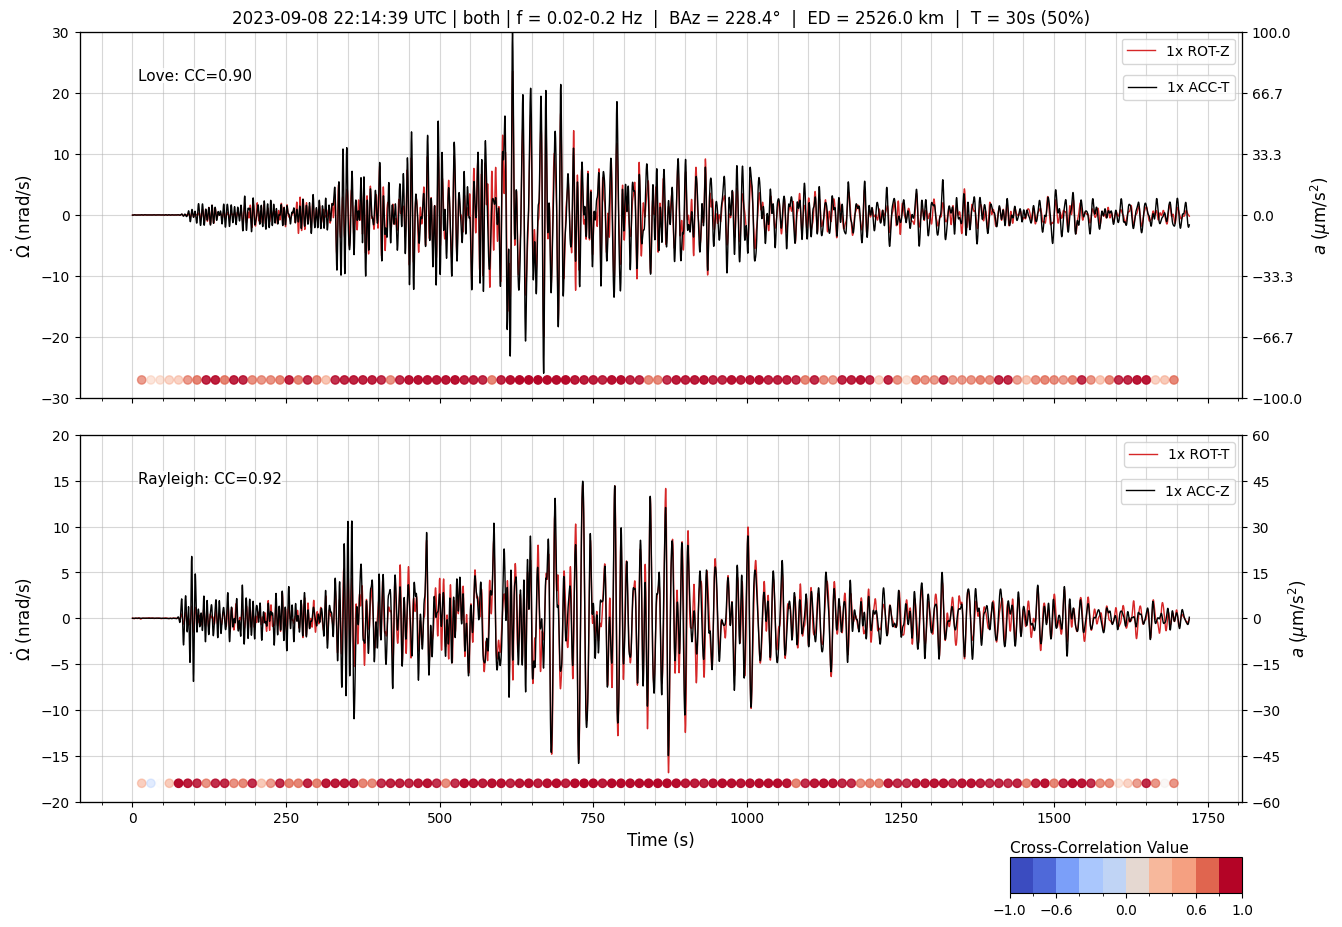

In [14]:
fig = plot_waveform_cc(
    sd_object=sd,
    twin_sec=config['twin_sec'],
    twin_overlap=config['twin_overlap'],
    wave_type="both"
)

Make spectra for the raw data

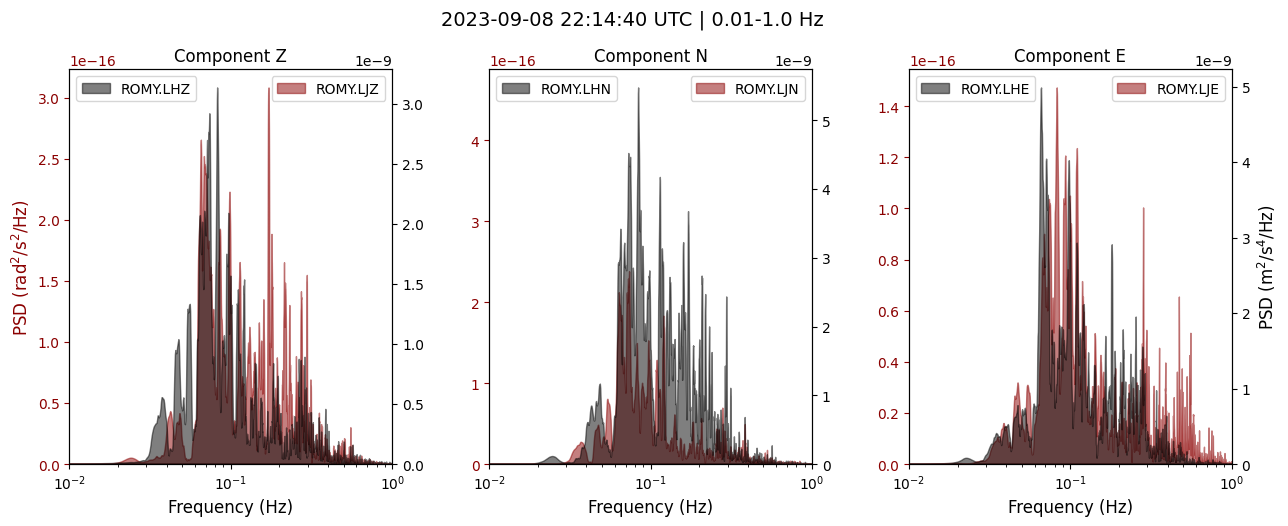

In [15]:
# Plot the spectra comparison
fig = plot_spectra_comparison_fill(
    rot=sd.get_stream("rotation", raw=True).copy(),
    acc=sd.get_stream("translation", raw=True).copy(),
    fmin=0.01,
    fmax=1.0,
    ylog=False,
    xlog=True,
    fill=True
)

Make spectra for the filtered data

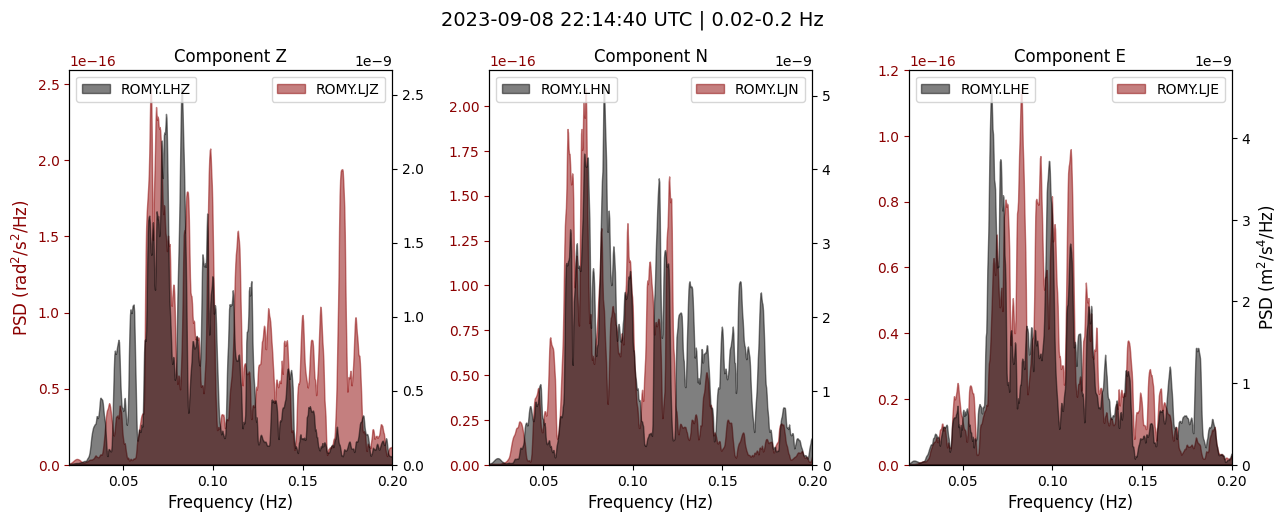

In [16]:
fig = plot_spectra_comparison_fill(
    sd_object=sd,
    ylog=False,
    xlog=False,
    fill=True
)

### Backazimuth Estimate

Computation of backazimuth results for Love waves using the midpoint CC-method

baz_max = 250, baz_std = 24


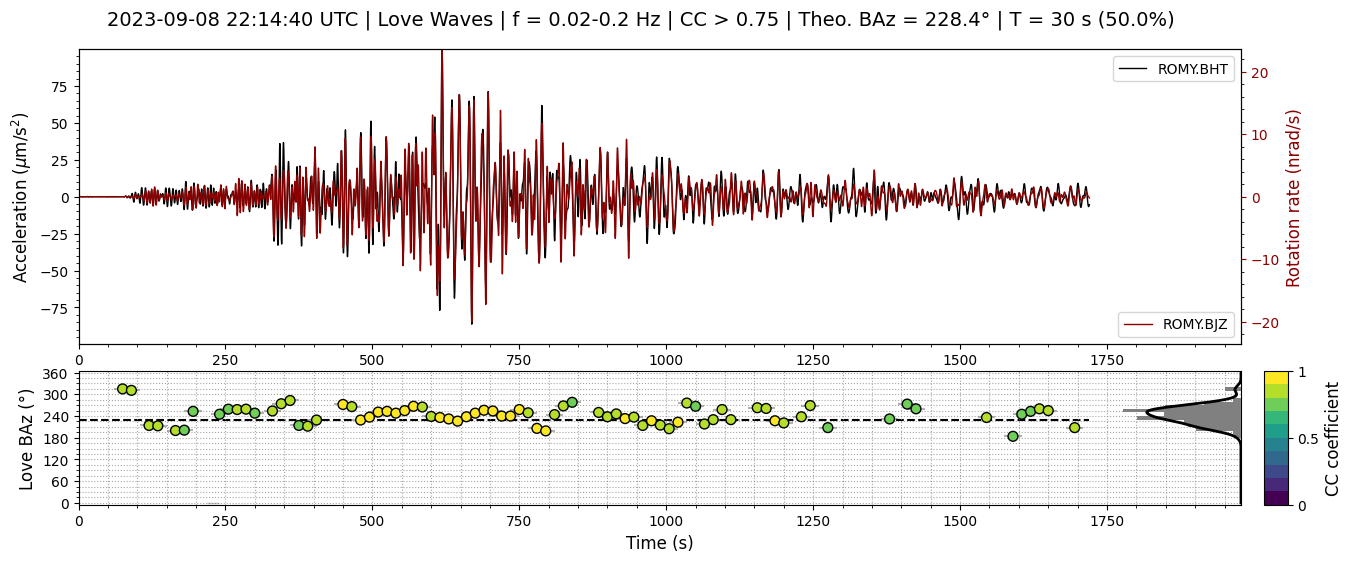

In [17]:
# First compute backazimuth
baz_results_love = sd.compute_backazimuth(
    wave_type='love',
    baz_step=config['baz_step'],
    baz_win_sec=config['twin_sec'],
    baz_win_overlap=config['twin_overlap'],
    out=True
)

# Then plot results
fig = plot_backazimuth_results(
    sd,
    baz_results_love,
    wave_type='love',
    cc_method='mid',
    baz_theo=ev['backazimuth'],
    cc_threshold=config['cc_threshold'],
)

Computation of backazimuth results for Rayleigh waves using the midpoint CC-method

baz_max = 234, baz_std = 13


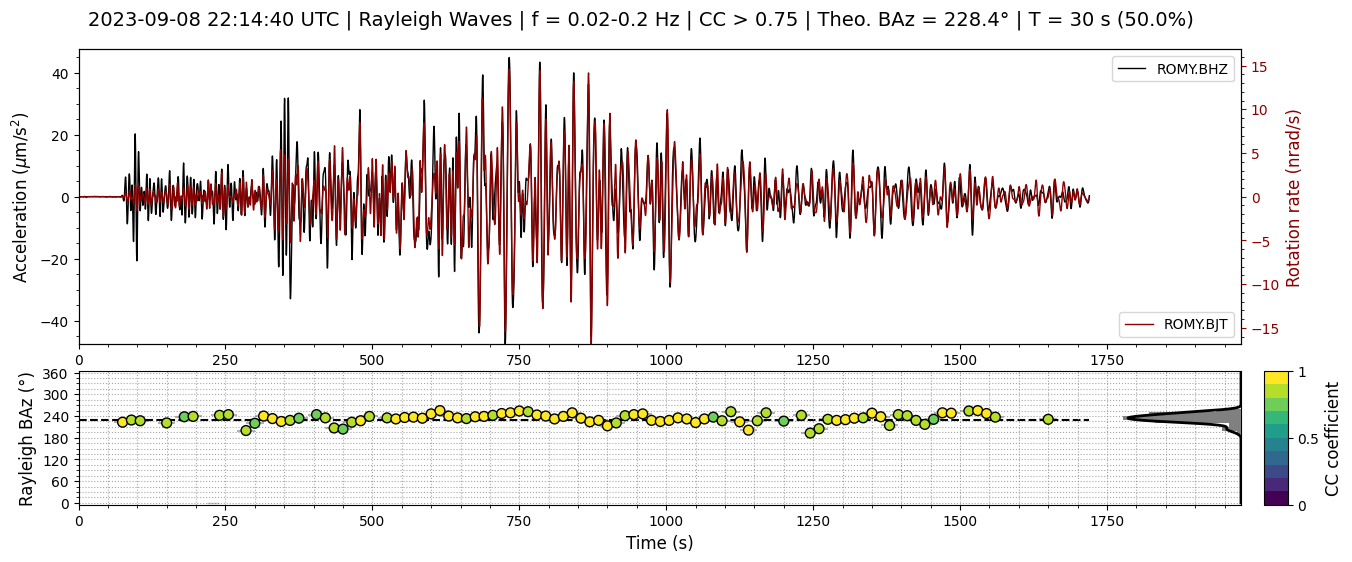

In [18]:
# First compute backazimuth
baz_results_rayleigh = sd.compute_backazimuth(
    wave_type='rayleigh',
    baz_step=config['baz_step'],
    baz_win_sec=config['twin_sec'],
    baz_win_overlap=config['twin_overlap'],
    out=True
)

# Then plot results
fig = plot_backazimuth_results(
    sd,
    baz_results_rayleigh,
    wave_type='rayleigh',
    baz_theo=ev['backazimuth'],
    cc_method='mid',
    cc_threshold=config['cc_threshold'],  # optional
)

Compare all three different methods for backazimuth estimation:

Using precomputed love backazimuth results

Estimated BAZ Love = 250° (CC ≥ 0.75)
Using precomputed rayleigh backazimuth results

Estimated BAZ Rayleigh = 234° (CC ≥ 0.75)
Computing tangent wave backazimuth...

Estimated BAZ Tangent = 235° (CC ≥ 0.75)


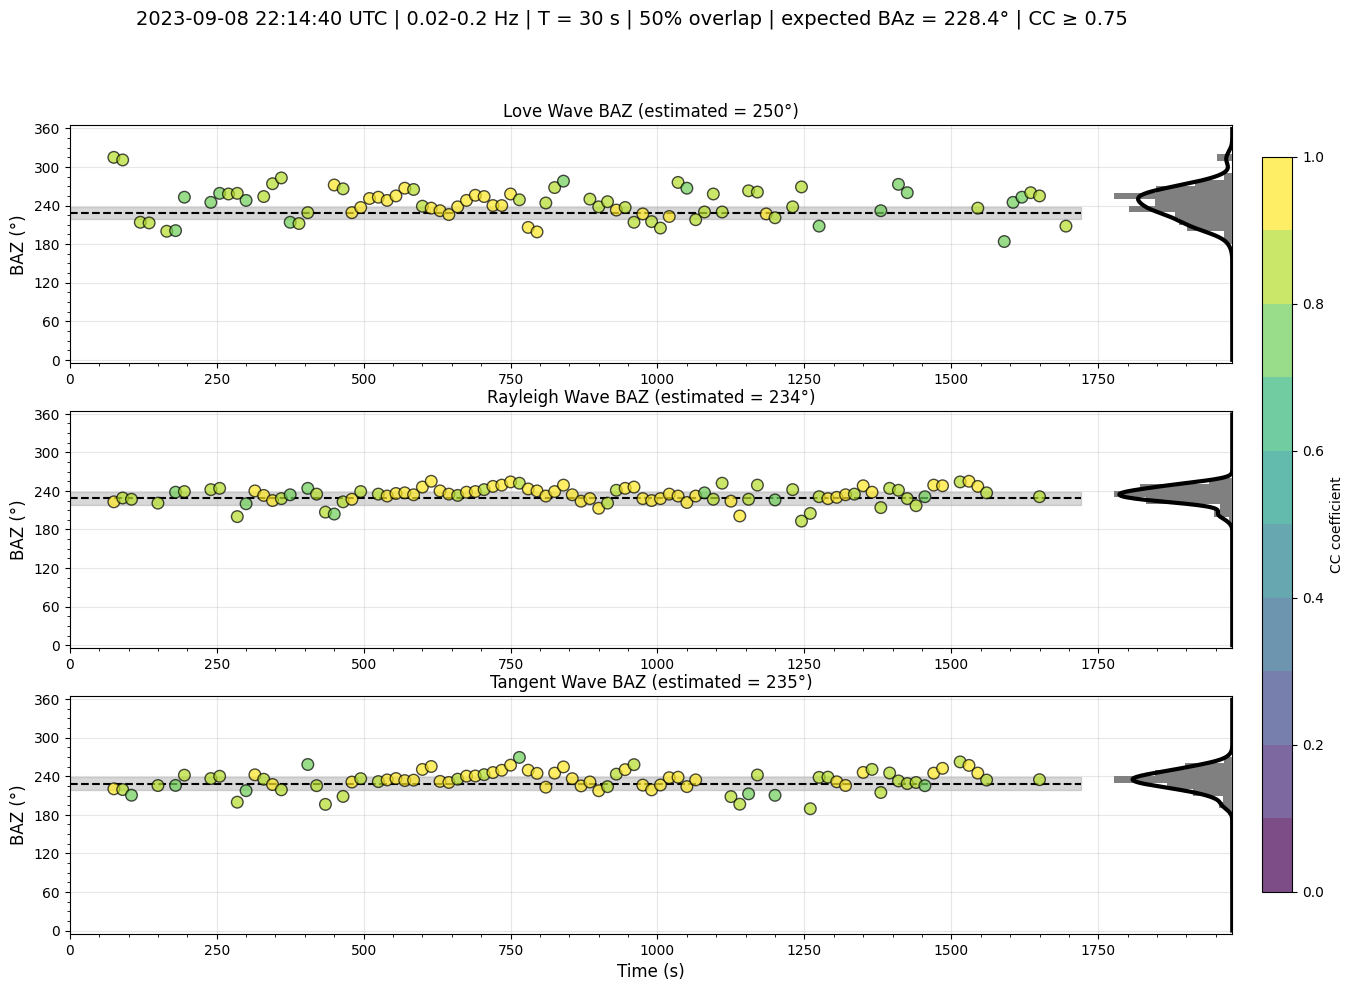

In [19]:
fig, _results = sd.compare_backazimuth_methods(
    Twin=config['twin_sec'],
    Toverlap=config['twin_overlap'],
    cc_threshold=config['cc_threshold'],
    baz_theo=ev['backazimuth'],
    cc_method='mid',
    plot=True,
    output=True
)

### Analyse phase velocities

In [20]:
# Compute Love wave velocities
love_velocities = sd.compute_velocities(
    wave_type='love',
    win_time_s=config['twin_sec'],
    overlap=config['twin_overlap'],
    cc_threshold=config['cc_threshold'],
    method='odr',  # 'odr' | 'ransac'
    baz=ev['backazimuth']  # theoretical backazimuth (optional)
)

# Compute Rayleigh wave velocities
rayleigh_velocities = sd.compute_velocities(
    wave_type='rayleigh',
    win_time_s=config['twin_sec'],
    overlap=config['twin_overlap'],
    cc_threshold=config['cc_threshold'],
    method='odr',  # 'odr' | 'ransac'
    baz=ev['backazimuth']  # theoretical backazimuth (optional)
)

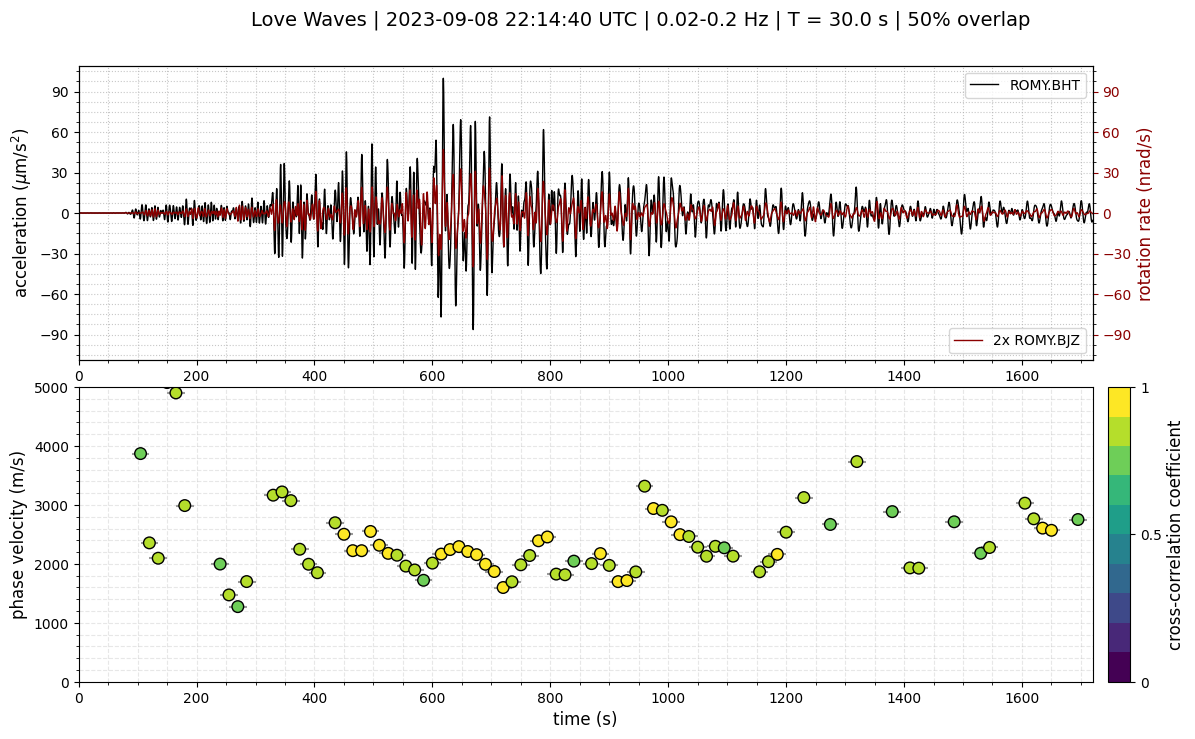

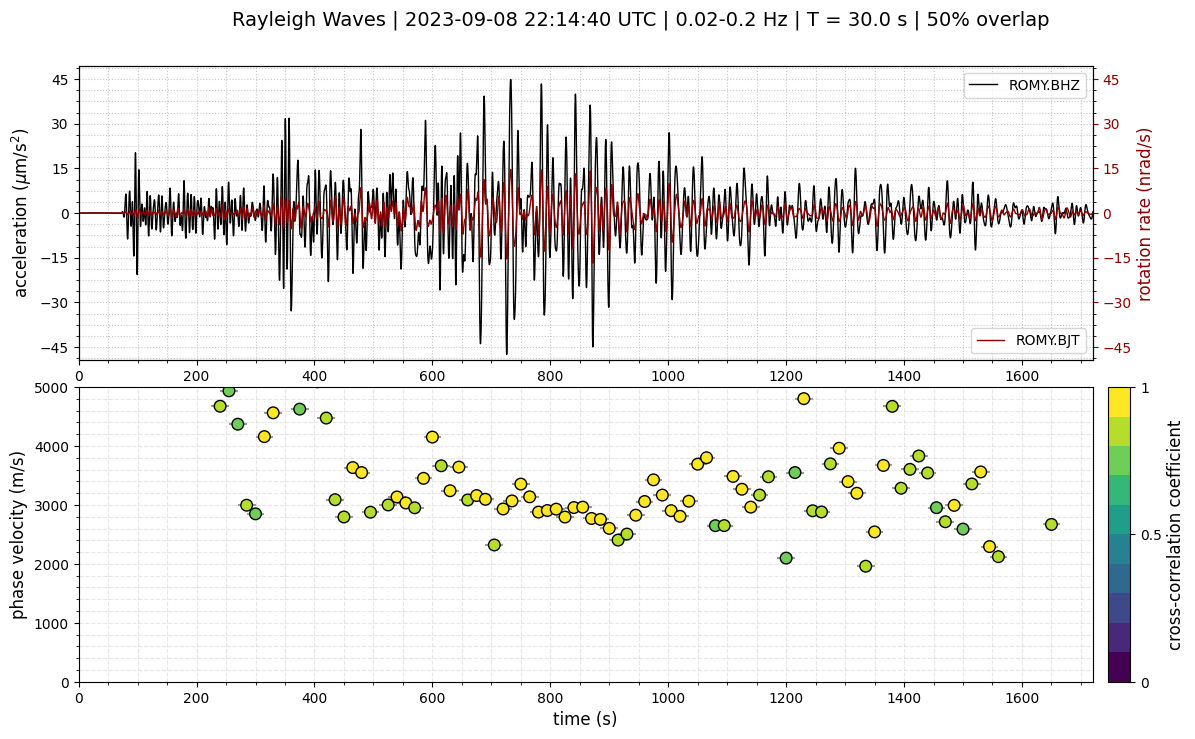

In [21]:
# Plot results
fig = plot_velocities(sd,
    velocity_results=love_velocities,
    vmax=5000,  # optional
    minors=True # optional
)

# Plot results
fig = plot_velocities(sd,
    velocity_results=rayleigh_velocities,
    vmax=5000,  # optional
    minors=True # optional
)

In [98]:
"""
Functions for plotting filtered traces in frequency bands for Rayleigh or Love waves.
"""
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Optional, Union, List, Tuple
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import AutoMinorLocator
from obspy import Stream
from obspy.signal.rotate import rotate_ne_rt


def plot_filtered_traces_frequency_bands(
    sd_object: Optional['sixdegrees'] = None,
    rot: Optional[Stream] = None,
    acc: Optional[Stream] = None,
    wave_type: str = "rayleigh",
    fmin: Optional[float] = None,
    fmax: Optional[float] = None,
    fraction_of_octave: int = 1,
    frequency_bands: Optional[List[Tuple[float, float]]] = None,
    baz: Optional[float] = None,
    unitscale: str = "nano",
    figsize: Optional[Tuple[float, float]] = None,
    title: Optional[str] = None,
    raw: bool = True,
    output: bool = False
) -> plt.Figure:
    """
    Plot filtered traces in frequency bands for Rayleigh or Love waves.
    
    Creates subpanels showing filtered traces for each frequency band, with velocity
    (black) on the left y-axis and rotation/angle (red) on the right y-axis.
    Both axes are aligned at zero.
    
    Parameters:
    -----------
    sd_object : sixdegrees, optional
        sixdegrees object. If provided, will extract rot and acc from sd_object.get_stream(),
        and extract baz, fmin, fmax from the object if not explicitly provided.
    rot : Stream, optional
        Rotation rate stream. Required if sd_object is not provided.
    acc : Stream, optional
        Acceleration stream. Required if sd_object is not provided.
    wave_type : str
        Wave type: "rayleigh" or "love"
    fmin : float, optional
        Minimum frequency for octave band generation. Required if frequency_bands is not provided.
    fmax : float, optional
        Maximum frequency for octave band generation. Required if frequency_bands is not provided.
    fraction_of_octave : int, optional
        Fraction of octave for octave band generation. If not provided, uses 1 (octaves).
    frequency_bands : list of tuples, optional
        List of (fmin, fmax) tuples for frequency bands. If provided, overrides fmin/fmax.
    baz : float, optional
        Backazimuth. If not provided and sd_object is given, will try to extract from sd_object.
    unitscale : str
        Unit scale: "nano" or "micro"
    figsize : tuple, optional
        Figure size (width, height). If None, uses default based on number of bands.
    title : str, optional
        Custom title for the plot. If None, generates automatic title.
    raw : bool
        If True and sd_object is provided, uses raw (unfiltered) stream data.
    output : bool
        If True, returns a dictionary with velocities and frequencies.
    Returns:
    --------
    fig : plt.Figure
        Figure object
    """
    # Validate wave_type
    wave_type = wave_type.lower()
    if wave_type not in ["rayleigh", "love"]:
        raise ValueError(f"wave_type must be 'rayleigh' or 'love', got '{wave_type}'")
    
    # Extract streams and parameters from sd_object if provided
    if sd_object is not None:
        # Extract streams if not provided
        if rot is None:
            rot = sd_object.get_stream("rotation", raw=raw)
        if acc is None:
            acc = sd_object.get_stream("translation", raw=raw)
        
        # Extract parameters if not explicitly provided
        if fmin is None and hasattr(sd_object, 'fmin') and sd_object.fmin is not None:
            fmin = sd_object.fmin
        if fmax is None and hasattr(sd_object, 'fmax') and sd_object.fmax is not None:
            fmax = sd_object.fmax
        
        # Extract baz if not provided
        if baz is None:
            # Try theoretical baz first
            if hasattr(sd_object, 'baz_theo') and sd_object.baz_theo is not None:
                baz = sd_object.baz_theo
            # Try theoretical_baz attribute
            elif hasattr(sd_object, 'theoretical_baz') and sd_object.theoretical_baz is not None:
                baz = sd_object.theoretical_baz
            # Try baz_estimated (may be a dict with wave_type keys)
            elif hasattr(sd_object, 'baz_estimated') and sd_object.baz_estimated is not None:
                if isinstance(sd_object.baz_estimated, dict):
                    baz_val = sd_object.baz_estimated.get(wave_type.lower(), None)
                    if baz_val is None:
                        baz_val = next(iter(sd_object.baz_estimated.values()), None)
                    baz = baz_val
                else:
                    baz = sd_object.baz_estimated
            # Try event_info
            elif hasattr(sd_object, 'event_info') and sd_object.event_info is not None:
                if isinstance(sd_object.event_info, dict) and 'backazimuth' in sd_object.event_info:
                    baz = sd_object.event_info['backazimuth']
    
    # Validate that we have required streams
    if rot is None or acc is None:
        raise ValueError("Either provide rot and acc directly, or provide sd_object (sixdegrees object)")
    
    # Validate that we have baz
    if baz is None:
        raise ValueError("baz (backazimuth) must be provided either directly or extractable from sd_object")
    
    # Determine frequency bands
    if frequency_bands is None:
        if fmin is None or fmax is None:
            raise ValueError("Either provide frequency_bands or both fmin and fmax")
        
        # Generate octave bands using sd_object method if available
        if sd_object is not None and hasattr(sd_object, 'get_octave_bands'):
            f_lower, f_upper, f_center = sd_object.get_octave_bands(fmin=fmin, fmax=fmax, faction_of_octave=fraction_of_octave)
            frequency_bands = [(fl, fu) for fl, fu in zip(f_lower, f_upper)]
        else:
            # Simple octave band generation if sd_object method not available
            frequency_bands = _generate_octave_bands(fmin, fmax)
    else:
        # Validate frequency_bands format
        if not isinstance(frequency_bands, list) or len(frequency_bands) == 0:
            raise ValueError("frequency_bands must be a non-empty list of (fmin, fmax) tuples")
        for band in frequency_bands:
            if not isinstance(band, (tuple, list)) or len(band) != 2:
                raise ValueError("Each frequency band must be a tuple/list of (fmin, fmax)")
    
    n_bands = len(frequency_bands)
    
    # Define scaling factors
    mu = r"$\mu$"
    if unitscale == "nano":
        acc_scaling, acc_unit = 1e6, f"{mu}m/s"
        rot_scaling, rot_unit = 1e9, f"nrad"
    elif unitscale == "micro":
        acc_scaling, acc_unit = 1e3, f"mm/s"
        rot_scaling, rot_unit = 1e6, f"{mu}rad"
    else:
        raise ValueError(f"Invalid unitscale: {unitscale}. Valid options are: 'nano', 'micro'")
    
    # Set figure size
    if figsize is None:
        figsize = (15, 2 * n_bands)
    
    # Create figure with subplots
    fig, axes = plt.subplots(n_bands, 1, figsize=figsize, sharex=True)
    if n_bands == 1:
        axes = [axes]
    
    plt.subplots_adjust(hspace=0.0)
    
    # Plot settings
    font = 12
    lw = 0.8
    
    # Get sampling rate
    dt = rot[0].stats.delta
    times = rot[0].times()
    
    out = {}
    out['velocities'] = np.ones(len(frequency_bands))*np.nan
    out['frequencies'] = np.ones(len(frequency_bands))*np.nan

    # Process each frequency band
    for i, (fl, fu) in enumerate(frequency_bands):
        ax = axes[i]
        
        # Remove bottom and top spines
        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)

        # Filter streams for this frequency band
        rot_filtered = rot.copy()
        acc_filtered = acc.copy()
        
        # Detrend and taper before filtering
        rot_filtered.detrend('linear')
        rot_filtered.detrend('demean')
        rot_filtered.taper(0.02, type='cosine')

        acc_filtered.detrend('linear')
        acc_filtered.detrend('demean')
        acc_filtered.taper(0.02, type='cosine')
        
        # Apply bandpass filter
        rot_filtered.filter('bandpass', freqmin=fl, freqmax=fu, corners=4, zerophase=True)
        acc_filtered.filter('bandpass', freqmin=fl, freqmax=fu, corners=4, zerophase=True)
        
        # Get components based on wave type
        if wave_type == "rayleigh":
            # Rayleigh: vertical velocity (acc_z) vs horizontal rotation (rot_t)
            acc_z = acc_filtered.select(channel="*Z")[0].data
            rot_r, rot_t = rotate_ne_rt(
                rot_filtered.select(channel="*N")[0].data,
                rot_filtered.select(channel="*E")[0].data,
                baz
            )
            
            # Apply scaling
            acc_z_scaled = acc_z * acc_scaling
            rot_t_scaled = rot_t * rot_scaling
            
            # Linear regression with only slope: tra = slope * rot
            # Calculate slope: slope = sum(tra * rot) / sum(rot * rot)
            slope = np.sum(acc_z_scaled * rot_t_scaled) / np.sum(rot_t_scaled * rot_t_scaled)
            
            out['velocities'][i] = slope*1e3
            out['frequencies'][i] = np.sqrt(2)*fu

            # Scale rotation data by the slope
            rot_t_scaled = rot_t_scaled * slope
            
            # Plot velocity (black) on left axis
            ax.plot(times, acc_z_scaled, color="black", lw=lw, label=f"v_Z")
            
            # Plot rotation (red) on right axis
            ax2 = ax.twinx()
            ax2.plot(times, rot_t_scaled, color="red", lw=lw, label=f"r_H")
                        
            # Remove bottom and top spines
            ax2.spines['bottom'].set_visible(False)
            ax2.spines['top'].set_visible(False)
            ax2.spines['right'].set_visible(False)
            ax2.spines['left'].set_visible(False)

            # Get max values for symmetric ylim
            acc_max = max([abs(np.min(acc_z_scaled)), abs(np.max(acc_z_scaled))])
            rot_max = max([abs(np.min(rot_t_scaled)), abs(np.max(rot_t_scaled))])
            
            # Set ylims symmetric around zero (ensures zero alignment)
            if acc_max > 0:
                ax.set_ylim(-acc_max * 1.05, acc_max * 1.05)
            else:
                ax.set_ylim(-1, 1)  # Default range if all zeros
            if rot_max > 0:
                ax2.set_ylim(-rot_max * 1.05, rot_max * 1.05)
            else:
                ax2.set_ylim(-1, 1)  # Default range if all zeros
            
            # Remove y-axis labels and ticks
            ax.set_ylabel("")
            ax2.set_ylabel("")
            ax.set_yticks([])
            ax2.set_yticks([])
            
            # Show scale factor as text
            ax.text(0.02, 0.8, f"scale: {slope*1e3:.0f} m/s", 
                    transform=ax.transAxes, fontsize=font-2,
                    rotation=0, va='center', ha='left')
            
        elif wave_type == "love":
            # Love: vertical rotation (rot_z) vs horizontal velocity (acc_t)
            rot_z = rot_filtered.select(channel="*Z")[0].data
            acc_r, acc_t = rotate_ne_rt(
                acc_filtered.select(channel="*N")[0].data,
                acc_filtered.select(channel="*E")[0].data,
                baz
            )
            
            # Apply scaling
            rot_z_scaled = rot_z * rot_scaling
            acc_t_scaled = acc_t * acc_scaling
            
            # Linear regression with only slope: tra = slope * rot
            # Calculate slope: slope = sum(tra * rot) / sum(rot * rot)
            slope = np.sum(acc_t_scaled * rot_z_scaled) / np.sum(rot_z_scaled * rot_z_scaled)

            out['velocities'][i] = slope*1e3
            out['frequencies'][i] = np.sqrt(2)*fu
            
            # Scale rotation data by the slope
            rot_z_scaled = rot_z_scaled * slope
            
            # Plot velocity (black) on left axis
            ax.plot(times, acc_t_scaled, color="black", lw=lw, label=f"v_H")
            
            # Plot rotation (red) on right axis
            ax2 = ax.twinx()
            ax2.plot(times, rot_z_scaled, color="red", lw=lw, label=f"r_Z")
            
            # Remove bottom and top spines
            ax2.spines['bottom'].set_visible(False)
            ax2.spines['top'].set_visible(False)
            ax2.spines['right'].set_visible(False)
            ax2.spines['left'].set_visible(False)
            
            # Get max values for symmetric ylim
            acc_max = max([abs(np.min(acc_t_scaled)), abs(np.max(acc_t_scaled))])
            rot_max = max([abs(np.min(rot_z_scaled)), abs(np.max(rot_z_scaled))])
            
            # Set ylims symmetric around zero (ensures zero alignment)
            if acc_max > 0:
                ax.set_ylim(-acc_max * 1.05, acc_max * 1.05)
            else:
                ax.set_ylim(-1, 1)  # Default range if all zeros
            if rot_max > 0:
                ax2.set_ylim(-rot_max * 1.05, rot_max * 1.05)
            else:
                ax2.set_ylim(-1, 1)  # Default range if all zeros
            
            # Remove y-axis labels and ticks
            ax.set_ylabel("")
            ax2.set_ylabel("")
            ax.set_yticks([])
            ax2.set_yticks([])
            
            # Show scale factor as text
            ax.text(0.02, 0.8, f"scale: {slope*1e3:.0f} m/s", 
                    transform=ax.transAxes, fontsize=font-2,
                    rotation=0, va='center', ha='left')
        
        # Set x-axis label only on bottom subplot
        if i == n_bands - 1:
            ax.set_xlabel("Time (s)", fontsize=font)
        
        # Add frequency band label on the right
        # Format frequency based on magnitude
        if fl < 0.1:
            fl_str = f"{fl:.3f}"
        elif fl < 1:
            fl_str = f"{fl:.2f}"
        else:
            fl_str = f"{fl:.1f}"
        
        if fu < 0.1:
            fu_str = f"{fu:.3f}"
        elif fu < 1:
            fu_str = f"{fu:.2f}"
        else:
            fu_str = f"{fu:.1f}"
        
        ax.text(0.99, 0.8, f"{fl_str}-{fu_str} Hz", 
                transform=ax.transAxes, fontsize=font-2,
                rotation=0, va='center', ha='right')
        
        # Add grid
        # ax.grid(True, which='both', ls='--', alpha=0.3)
        # ax.xaxis.set_minor_locator(AutoMinorLocator())
        # ax.yaxis.set_minor_locator(AutoMinorLocator())
    
    ax.spines['bottom'].set_visible(True)

    # Set title
    if title is None:
        # Generate automatic title
        start_time = acc[0].stats.starttime
        title = f"{wave_type.capitalize()} waves"
        if baz is not None:
            title += f" | BAz = {baz:.1f}°"
        title += f" | {start_time.strftime('%Y-%m-%d %H:%M:%S')} UTC"
    
    fig.suptitle(title, fontsize=font+2, y=0.93)
    
    if output:
        return fig, out
    else:
        return fig


def _generate_octave_bands(fmin: float, fmax: float) -> List[Tuple[float, float]]:
    """
    Generate octave frequency bands between fmin and fmax.
    
    Parameters:
    -----------
    fmin : float
        Minimum frequency
    fmax : float
        Maximum frequency
        
    Returns:
    --------
    bands : list of tuples
        List of (fmin, fmax) tuples for each octave band
    """
    bands = []
    f = fmin
    
    while f < fmax:
        f_next = f * 2  # Next octave
        if f_next > fmax:
            f_next = fmax
        bands.append((f, f_next))
        f = f_next
    
    return bands


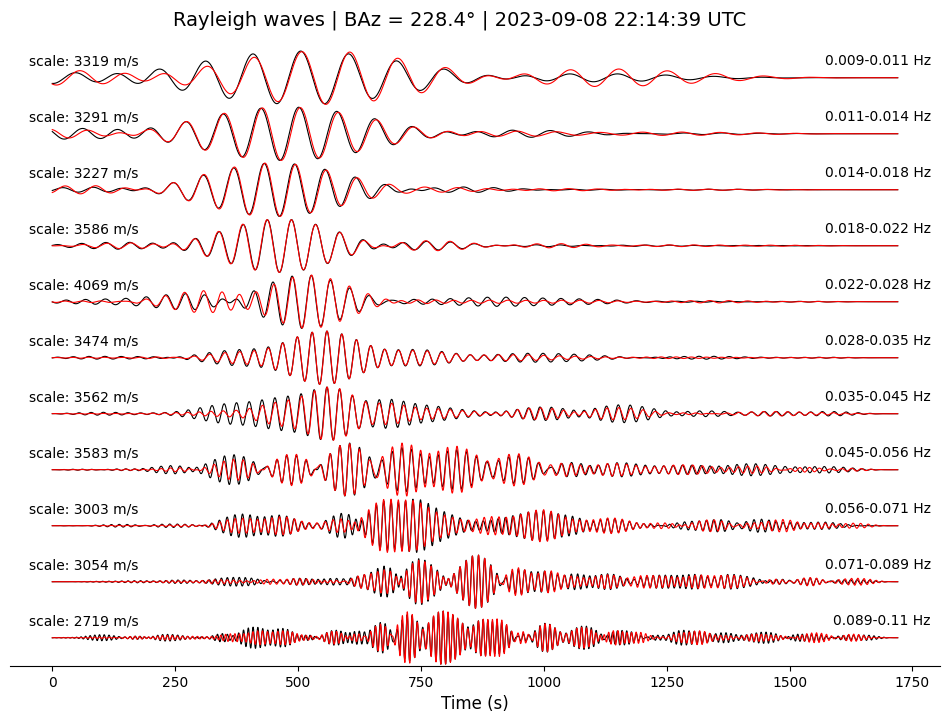

In [99]:
# from sixdegrees.plots.plot_filtered_traces_frequency_bands import plot_filtered_traces_frequency_bands

fig, disp_rayleigh = plot_filtered_traces_frequency_bands(
    sd_object=sd,
    wave_type="rayleigh",
    fmin=0.01,
    fmax=0.1,
    fraction_of_octave=3,
    baz=ev['backazimuth'],
    figsize=(12, 8),
    output=True
)

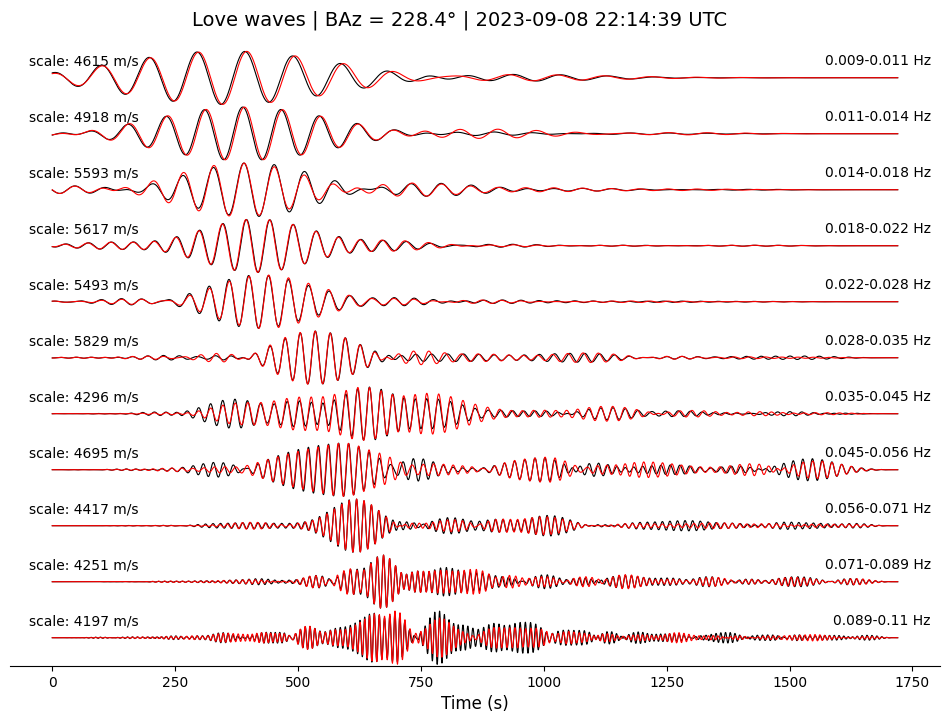

In [107]:
fig, disp_love = plot_filtered_traces_frequency_bands(
    sd_object=sd,
    wave_type="Love",
    fmin=0.01,
    fmax=0.1,
    fraction_of_octave=3,
    baz=ev['backazimuth'],
    figsize=(12, 8),
    output=True
)


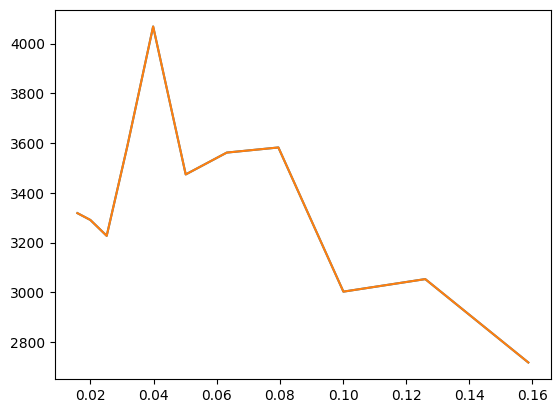

In [ ]:
plt.plot(disp_rayleigh['frequencies'], disp_rayleigh['velocities'])
plt.plot(disp_love['frequencies'], disp_love['velocities'])